#### Cargar data

In [1]:
import torch

if torch.cuda.is_available():
    print("CUDA disponible. Configuraciones de CUDA:")
    print("Cantidad de GPUs disponibles:", torch.cuda.device_count())
    print("Nombre de la GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA no está disponible. PyTorch está utilizando la CPU.")


CUDA disponible. Configuraciones de CUDA:
Cantidad de GPUs disponibles: 1
Nombre de la GPU: NVIDIA GeForce RTX 4070


In [2]:
import os
import re  
import torch
from torch_geometric.utils import to_dense_adj  
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import gc 
def orden_numerico(archivo):
    numero = re.search(r'\d+', archivo)
    if numero:
        return int(numero.group())
    return 0

ruta_guardado = "Dades/Snapshots"

if not os.path.exists(ruta_guardado):
    raise RuntimeError(f"La ruta especificada no existe: {ruta_guardado}")

snapshots_reestructurados = []
num_archivos_intentados = 0
num_archivos_cargados = 0

archivos = [archivo for archivo in os.listdir(ruta_guardado) if archivo.endswith('.pt')]

archivos_ordenados = sorted(archivos, key=orden_numerico)

for archivo in archivos_ordenados:
    num_archivos_intentados += 1
    ruta_archivo = os.path.join(ruta_guardado, archivo)
    try:
        snapshot = torch.load(ruta_archivo)
        print(f"cargando el archivo {archivo}")
        snapshots_reestructurados.append(snapshot)
        del snapshot
        gc.collect()
        
        
        num_archivos_cargados += 1
    except Exception as e:
        print(f"Error al cargar el archivo {archivo}: {e}")

print(f"{num_archivos_cargados} de {num_archivos_intentados} archivos han sido cargados correctamente.")


cargando el archivo snapshot_6.pt
cargando el archivo snapshot_7.pt
cargando el archivo snapshot_8.pt
cargando el archivo snapshot_9.pt
cargando el archivo snapshot_10.pt
cargando el archivo snapshot_11.pt
cargando el archivo snapshot_12.pt
cargando el archivo snapshot_13.pt
cargando el archivo snapshot_14.pt
cargando el archivo snapshot_15.pt
cargando el archivo snapshot_16.pt
cargando el archivo snapshot_17.pt
cargando el archivo snapshot_18.pt
cargando el archivo snapshot_19.pt
cargando el archivo snapshot_20.pt
cargando el archivo snapshot_21.pt
cargando el archivo snapshot_22.pt
cargando el archivo snapshot_23.pt
cargando el archivo snapshot_24.pt
cargando el archivo snapshot_25.pt
cargando el archivo snapshot_26.pt
cargando el archivo snapshot_27.pt
cargando el archivo snapshot_28.pt
cargando el archivo snapshot_29.pt
cargando el archivo snapshot_30.pt
cargando el archivo snapshot_31.pt
cargando el archivo snapshot_32.pt
cargando el archivo snapshot_33.pt
cargando el archivo snap

In [3]:
snapshots_reestructurados[0]

Data(x=[512, 385], edge_index=[2, 3498], edge_attr=[3498, 1], y=[512, 48])

In [4]:
x_dims = [snapshot.x.size() for snapshot in snapshots_reestructurados if hasattr(snapshot, 'x')]
consistent_x_dims = all(x == x_dims[0] for x in x_dims)

y_dims = [snapshot.y.size() for snapshot in snapshots_reestructurados if hasattr(snapshot, 'y')]
consistent_y_dims = all(y == y_dims[0] for y in y_dims)

print(f"Todas las dimensiones de 'x' son consistentes: {consistent_x_dims}")
print(f"Todas las dimensiones de 'y' son consistentes: {consistent_y_dims}")


Todas las dimensiones de 'x' son consistentes: True
Todas las dimensiones de 'y' son consistentes: True


In [132]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj   
total_datos = len(snapshots_reestructurados)
train_size = int(0.7 * total_datos)
val_size = int(0.15 * total_datos)
test_size = total_datos - train_size - val_size

train_dataset = snapshots_reestructurados[:train_size]
val_dataset = snapshots_reestructurados[train_size:train_size + val_size]
test_dataset = snapshots_reestructurados[train_size + val_size:]


umbral_std = 1e-6


all_train_data = torch.cat([data.x for data in train_dataset])

mean = torch.mean(all_train_data, axis=0)
std = torch.std(all_train_data, axis=0)
std[std < umbral_std] = 1

def normalize_dataset(dataset, mean, std):
    for data in dataset:
        data.x = ((data.x.to(torch.float64) - mean) / std).to(torch.float32) 
    return dataset

train_dataset = normalize_dataset(train_dataset, mean, std)
val_dataset = normalize_dataset(val_dataset, mean, std)
test_dataset = normalize_dataset(test_dataset, mean, std)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
 
adj_matrix = to_dense_adj(snapshots_reestructurados[0].edge_index)



batch_size = 1  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch in train_loader:
    print("Tamaño del lote (número de grafos):", batch.num_graphs)
    print("Características del primer grafo del lote:", batch[0].x.shape)
    print("Etiquetas del primer grafo del lote:", batch[0].y.shape)
    break

9198
1971
1972
Tamaño del lote (número de grafos): 1
Características del primer grafo del lote: torch.Size([512, 385])
Etiquetas del primer grafo del lote: torch.Size([512, 48])


#### Model

In [148]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GPRConv(MessagePassing):
    def __init__(self, in_channels, out_channels, K):
        super(GPRConv, self).__init__(aggr='mean')
        self.lin = nn.ModuleList([nn.Linear(in_channels, in_channels) for _ in range(K+1)])
        self.final_lin = nn.Linear(in_channels, out_channels)
        self.K = K
        self.alpha = torch.nn.Parameter(torch.Tensor(self.K+1).uniform_(-0.01, 0.01))

    def forward(self, x, edge_index):

        self.alpha = self.alpha.to(x.device)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        Z = [self.lin[0](x)]
        for k in range(1, self.K+1):
            Z.append(self.lin[k](self.propagate(edge_index, x=Z[-1], norm=norm)))
        Z = torch.stack(Z, dim=0)
        Z = torch.einsum('k,kij->ij', self.alpha, Z)
        return self.final_lin(Z)

class GPRGNN(nn.Module):
    def __init__(self,adj_train, num_features, num_future_steps, num_target_variables, hidden_channels, K, dropout):
        super(GPRGNN, self).__init__()
        output_channels = num_future_steps * num_target_variables


        k1 = 50
        adj_train_squeeze = adj_train.squeeze(0)
        u_A, s_A, _ = torch.svd(adj_train_squeeze)
        u_A_k1 = u_A[:, :k1]
        input_channels = num_features + k1
        self.non_linear = nn.Sequential(
            nn.Linear(input_channels, hidden_channels * 2),
            nn.ReLU(),
            nn.Linear(hidden_channels * 2, hidden_channels),  
            nn.ELU()
        )

        self.combine = nn.Sequential(
            nn.Linear( hidden_channels//4, output_channels),
            nn.LeakyReLU(),
            nn.Linear(output_channels, output_channels),
            nn.ReLU()
        )

        self.dropout = nn.Dropout(dropout)
        
        self.c = GPRConv(hidden_channels, hidden_channels//2, K)
        self.c1 = GPRConv(hidden_channels//2, hidden_channels//4, K)

        self.register_buffer("u_A_k1", u_A_k1)

    def forward(self, x, edge_index):
       
        x = torch.cat([x, self.u_A_k1], dim=1)
        x = self.non_linear(x)
        x = self.c(x, edge_index)
        x = self.c1(x, edge_index)
        x = self.dropout(x)
        x = self.combine(x)

        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GPRGNN(
    adj_train=adj_matrix, 
    num_features=385,  
    num_future_steps=6,  
    num_target_variables=8, 
    hidden_channels=385, 
    K=1,  
    dropout=0.3
)
model.to(device)

GPRGNN(
  (non_linear): Sequential(
    (0): Linear(in_features=435, out_features=770, bias=True)
    (1): ReLU()
    (2): Linear(in_features=770, out_features=385, bias=True)
    (3): ELU(alpha=1.0)
  )
  (combine): Sequential(
    (0): Linear(in_features=96, out_features=48, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=48, out_features=48, bias=True)
    (3): ReLU()
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (c): GPRConv()
  (c1): GPRConv()
)

In [149]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.HuberLoss()
#criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, verbose=True)

#device = torch.device( 'cpu')
model.to(device)


def train(model, train_loader):
    model.train()
    total_loss = 0
  

    for data in train_loader:
        torch.autograd.set_detect_anomaly(True)
        data = data.to(device)
        
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)

        loss.backward(retain_graph=True) 

        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            total_loss += loss.item()
    return total_loss / len(val_loader)

num_epochs = 100
best_val_loss = float('inf')
best_model = None

for epoch in range(num_epochs):
    train_loss = train(model, train_loader)
    val_loss = validate(model, val_loader)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        torch.save(model.state_dict(), 'best_model.pth')

model.load_state_dict(torch.load('best_model.pth'))


c:\Users\marcs\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 1, Train Loss: 5.8573, Validation Loss: 4.6481
Epoch: 2, Train Loss: 3.8555, Validation Loss: 4.0085
Epoch: 3, Train Loss: 3.6431, Validation Loss: 3.8577
Epoch: 4, Train Loss: 3.2740, Validation Loss: 3.5438
Epoch: 5, Train Loss: 3.1436, Validation Loss: 3.5644
Epoch: 6, Train Loss: 3.0494, Validation Loss: 3.3824
Epoch: 7, Train Loss: 2.9791, Validation Loss: 3.4650
Epoch: 8, Train Loss: 2.9499, Validation Loss: 3.3488
Epoch: 9, Train Loss: 2.9314, Validation Loss: 3.3339
Epoch: 10, Train Loss: 2.9179, Validation Loss: 3.3705
Epoch: 11, Train Loss: 2.8973, Validation Loss: 3.3538
Epoch: 12, Train Loss: 2.8778, Validation Loss: 3.3385
Epoch: 13, Train Loss: 2.8675, Validation Loss: 3.3889
Epoch: 14, Train Loss: 2.8506, Validation Loss: 3.2814
Epoch: 15, Train Loss: 2.8276, Validation Loss: 3.3302
Epoch: 16, Train Loss: 2.8202, Validation Loss: 3.3066
Epoch: 17, Train Loss: 2.8116, Validation Loss: 3.2466
Epoch: 18, Train Loss: 2.8045, Validation Loss: 3.3029
Epoch: 19, Train Lo

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

#### Metricas

In [164]:
import numpy as np
import torch
nombres_compuestos = ["C6H6", "CO", "NO2", "NOx", "O3", "PM10", "PM25", "SO2"]
def calculate_metrics(outputs, targets):
    mse = criterion(outputs, targets)
    rmse = torch.sqrt(mse)
    mae = torch.mean(torch.abs(outputs - targets))

    outputs_np = outputs.detach().cpu().numpy()
    targets_np = targets.detach().cpu().numpy()

    if np.std(outputs_np) > 0 and np.std(targets_np) > 0:
        correlation = np.corrcoef(outputs_np.ravel(), targets_np.ravel())[0, 1]
    else:
        correlation = np.nan

    return mse.item(), rmse.item(), mae.item(), correlation

def test(model, test_loader, num_compounds, num_steps, nombres_compuestos):
    model.eval()
    device = next(model.parameters()).device  
    metrics_per_step_compound = [[[[] for _ in range(num_steps)] for _ in range(num_compounds)]]

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            
            out = model(data.x, data.edge_index)
          
            out = out.view(-1, num_compounds, num_steps ).to(device)
            y = data.y.view(-1, num_compounds, num_steps).to(device)
            
            for j in range(num_compounds):
                for i in range(num_steps):
                    mse, rmse, mae, corr = calculate_metrics(out[:, j, i], y[:, j, i])
                    metrics_per_step_compound[0][j][i].append((mse, rmse, mae, corr))

    averaged_metrics = [[[np.mean(metrics, axis=0) for metrics in step_compounds] for step_compounds in step_metrics] for step_metrics in metrics_per_step_compound]

    return averaged_metrics


num_compounds = 8 
num_steps = 6     
averaged_metrics = test(model, test_loader, num_compounds, num_steps, nombres_compuestos)


In [165]:
for j in range(num_compounds):
        for i in range(num_steps):
            mse, rmse, mae, corr = averaged_metrics[0][j][i]
            print(f"Paso {i+1}, Compuesto {nombres_compuestos[j]} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Paso 1, Compuesto C6H6 - MSE: 0.0415, RMSE: 0.1989, MAE: 0.1783
Paso 2, Compuesto C6H6 - MSE: 0.0412, RMSE: 0.1981, MAE: 0.1782
Paso 3, Compuesto C6H6 - MSE: 0.0406, RMSE: 0.1967, MAE: 0.1766
Paso 4, Compuesto C6H6 - MSE: 0.0409, RMSE: 0.1976, MAE: 0.1776
Paso 5, Compuesto C6H6 - MSE: 0.0418, RMSE: 0.1998, MAE: 0.1795
Paso 6, Compuesto C6H6 - MSE: 0.0424, RMSE: 0.2011, MAE: 0.1794
Paso 1, Compuesto CO - MSE: 0.0480, RMSE: 0.2180, MAE: 0.2754
Paso 2, Compuesto CO - MSE: 0.0480, RMSE: 0.2180, MAE: 0.2754
Paso 3, Compuesto CO - MSE: 0.0078, RMSE: 0.0874, MAE: 0.0779
Paso 4, Compuesto CO - MSE: 0.0480, RMSE: 0.2181, MAE: 0.2755
Paso 5, Compuesto CO - MSE: 0.0078, RMSE: 0.0874, MAE: 0.0783
Paso 6, Compuesto CO - MSE: 0.0078, RMSE: 0.0873, MAE: 0.0779
Paso 1, Compuesto NO2 - MSE: 3.0558, RMSE: 1.7131, MAE: 3.4869
Paso 2, Compuesto NO2 - MSE: 3.2156, RMSE: 1.7552, MAE: 3.6456
Paso 3, Compuesto NO2 - MSE: 3.1892, RMSE: 1.7452, MAE: 3.6182
Paso 4, Compuesto NO2 - MSE: 3.2891, RMSE: 1.7724, MAE:

In [169]:
import numpy as np


medias_por_compuesto = []

for j in range(num_compounds):
    metrics_compound = [averaged_metrics[0][j][i] for i in range(num_steps)]  
    metrics_array = np.array(metrics_compound) 
    mean_metrics = np.mean(metrics_array, axis=0)  
    medias_por_compuesto.append(mean_metrics)

for i, mean_metrics in enumerate(medias_por_compuesto):
    mse, rmse, mae, corr = mean_metrics
    print(f"Media para {nombres_compuestos[i]} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")


Media para C6H6 - MSE: 0.0414, RMSE: 0.1987, MAE: 0.1783
Media para CO - MSE: 0.0279, RMSE: 0.1527, MAE: 0.1767
Media para NO2 - MSE: 3.1887, RMSE: 1.7455, MAE: 3.6190
Media para NOx - MSE: 5.4492, RMSE: 2.2793, MAE: 5.9010
Media para O3 - MSE: 6.1270, RMSE: 2.4605, MAE: 6.6001
Media para PM10 - MSE: 2.8908, RMSE: 1.6679, MAE: 3.3027
Media para PM25 - MSE: 1.1082, RMSE: 1.0365, MAE: 1.4666
Media para SO2 - MSE: 0.3649, RMSE: 0.5926, MAE: 0.5870


In [153]:
import matplotlib.pyplot as plt

def test_and_collect(model, test_loader, num_compounds, num_steps, nombres_compuestos):
    model.eval()
    device = next(model.parameters()).device
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index)
            y = data.y.view(-1, num_compounds, num_steps).to(device)
            
            out = out.view(-1, num_compounds, num_steps).detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            
            all_outputs.append(out)
            all_targets.append(y)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    return all_outputs, all_targets

outputs, targets = test_and_collect(model, test_loader, num_compounds, num_steps, nombres_compuestos)




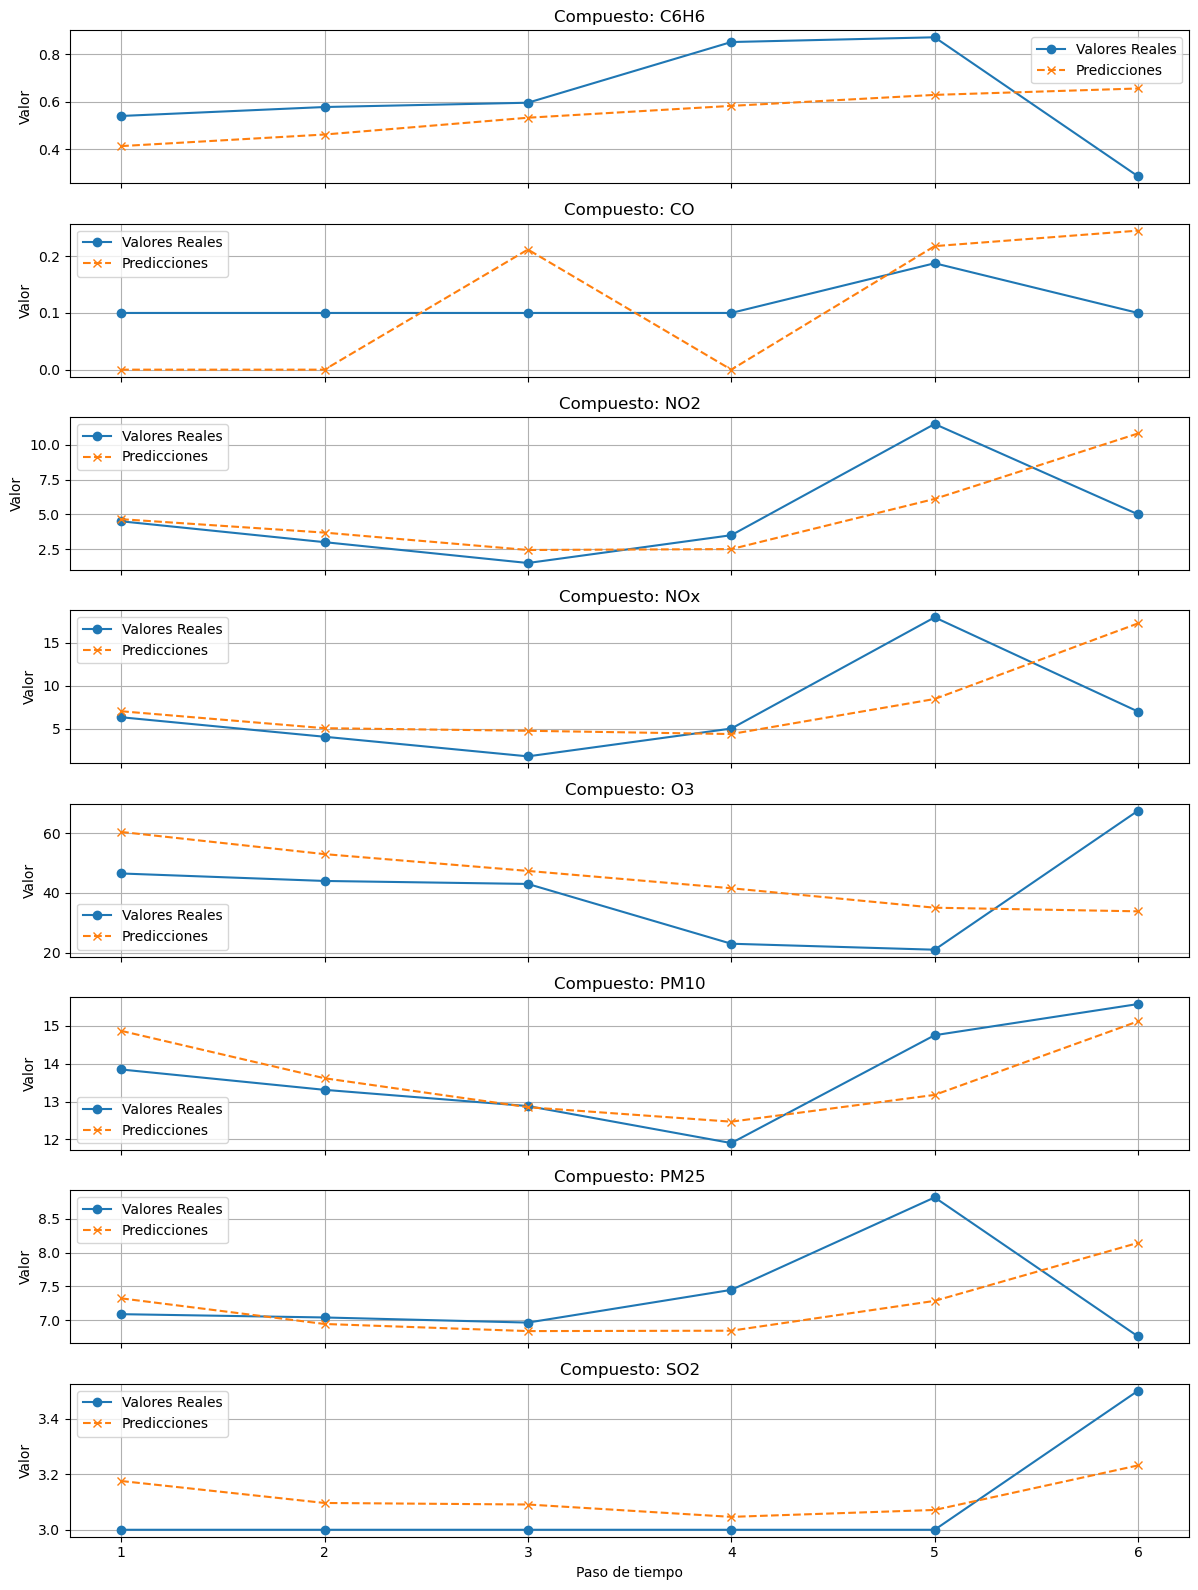

In [162]:
def plot_compound_predictions(outputs, targets, nombres_compuestos, sample_index):
    num_compounds = outputs.shape[1]
    num_steps = outputs.shape[2]
    steps = range(1, num_steps + 1)

    fig, axes = plt.subplots(nrows=num_compounds, ncols=1, figsize=(12, 2 * num_compounds), sharex=True)
    
    for i in range(num_compounds):
        ax = axes[i] if num_compounds > 1 else axes
        ax.plot(steps, targets[sample_index, i, :], 'o-', label='Valores Reales')
        ax.plot(steps, outputs[sample_index, i, :], 'x--', label='Predicciones')
        ax.set_title(f'Compuesto: {nombres_compuestos[i]}')
        ax.set_ylabel('Valor')
        ax.legend()
        ax.grid(True)
    
    plt.xlabel('Paso de tiempo')
    plt.tight_layout()
    plt.show()

plot_compound_predictions(outputs, targets, nombres_compuestos, sample_index=3697)
